# Visualize bathymetry with pyvista

In [ ]:
pip install 'pyvista[all]' pyvista-xarray geovista trame trame-vtk trame-vuetify

In [2]:
import matplotlib.pyplot as plt
import pyvista as pv
import xarray as xr
import numpy as np
import s3fs

In [3]:
fs = s3fs.S3FileSystem(
    anon=False,
    profile="gfts",
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
        "region_name": "gra",
    },
)

## Read Gridded Bathymetry Data

- Gridded ba from https://www.gebco.net/data_and_products/gridded_bathymetry_data/ 

In [4]:
gfts_url = "s3://gfts-reference-data/GEBCO_2023_sub_ice_topo.nc"

dset = xr.open_dataset(fs.open(gfts_url))
dset

<xarray.Dataset> Size: 7GB
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 346kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    elevation  (lat, lon) int16 7GB ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/836f016a-33be-6ddc-e053-6c86abc0788e
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

In [5]:
bbox = {"latitude": [45, 52], "longitude": [-9, 0]}

In [6]:
dset_area = dset.where(
    (dset.lat >= bbox["latitude"][0])
    & (dset.lat <= bbox["latitude"][1])
    & (dset.lon >= bbox["longitude"][0])
    & (dset.lon <= bbox["longitude"][1]),
    drop=True,
)

In [7]:
dset_area

<xarray.Dataset> Size: 15MB
Dimensions:    (lat: 1680, lon: 2160)
Coordinates:
  * lon        (lon) float64 17kB -8.998 -8.994 -8.99 ... -0.00625 -0.002083
  * lat        (lat) float64 13kB 45.0 45.01 45.01 45.01 ... 51.99 51.99 52.0
Data variables:
    elevation  (lat, lon) float32 15MB -4.897e+03 -4.9e+03 ... 143.0 114.0
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/836f016a-33be-6ddc-e053-6c86abc0788e
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

## 3D Visualisation with matplotlib

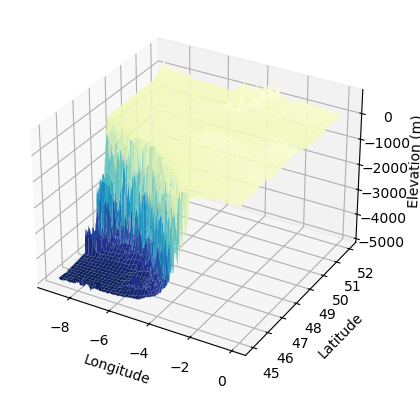

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")


# Creating data
x = dset_area.lon.values
y = dset_area.lat.values

Z = dset_area.elevation.values

X, Y = np.meshgrid(x, y)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r"Longitude")
ax.set_ylabel(r"Latitude")
ax.set_zlabel(r"Elevation (m)")

plt.show()

## Interactive visualisation with pyVista

In [9]:
pv.start_xvfb()

In [ ]:
dset_area.where(dset_area.elevation < 0).elevation.pyvista.plot(
    x="lon", y="lat", show_edges=False, cpos="xy"
)

## Interactive 3D visualisation with pyvista

In [ ]:
# Create and plot structured grid
grid = pv.StructuredGrid(X, Y, Z)
plotter = pv.Plotter()
plotter.add_mesh(
    grid,
    scalars=grid.points[:, -1],
    show_edges=False,
    scalar_bar_args={"vertical": False},
)
plotter.set_scale(zscale=0.001)
plotter.camera_position = "xy"
plotter.show()